In [1]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray as xr
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import math



In [2]:

print("Loading elevation dataset...")
elevation_dataset = rioxarray.open_rasterio(r"../local_dataset/dataset/elevation_full.tif", masked=True)
elevation_dataset = elevation_dataset[0]

print("Loading soil dataset...")
soil_dataset = pd.read_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet")

# print("Loading fire dataset...")
# fire_dataset = pd.read_parquet(r"../local_dataset/dataset/fire_full.parquet", engine="fastparquet")

print("Loading merged dataset...")
merged_dataset = pd.read_parquet(r"../local_dataset/dataset/buffer_kdtree.parquet", engine="fastparquet")




Loading elevation dataset...
Loading soil dataset...
Loading merged dataset...


In [3]:
print("Elevation dataset shape:", elevation_dataset.shape)
print(elevation_dataset.rio.crs)
print(elevation_dataset.dtype)

print("=============================\n" * 3, end='')
print("Soil dataset shape:", soil_dataset.shape)
print(soil_dataset.dtypes)

# print("=============================\n" * 3, end='')
# print("Fire dataset shape:", fire_dataset.shape)
# print(fire_dataset.dtypes)

print("=============================\n" * 3, end='')
print("Merged dataset shape:", merged_dataset.shape)
print(merged_dataset.dtypes)

Elevation dataset shape: (4392, 4965)
EPSG:4326
float32
Soil dataset shape: (7109938, 24)
lon              float64
lat              float64
COARSE           float64
SAND             float64
SILT             float64
CLAY             float64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL         float64
CEC_CLAY         float64
CEC_EFF          float64
TEB              float64
BSAT             float64
ALUM_SAT         float64
ESP              float64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND        float64
dtype: object
Merged dataset shape: (56864, 18)
lon                       float64
lat                       float64
fire                        int64
log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                 

# Merge dataset with elevation

In [4]:
merged_dataset['elevation'] = elevation_dataset.sel(
    x=xr.DataArray(merged_dataset.lon, dims="points"),
    y=xr.DataArray(merged_dataset.lat, dims="points"),
    method="nearest"
).values
print("Merged dataset shape:", merged_dataset.shape)
print(merged_dataset.head())

Merged dataset shape: (56864, 19)
            lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
index                                                                          
0       9.48947  31.49290     1       3.906307       1.287854       0.405465   
1       9.49053  31.49524     1       3.906307       1.287854       0.405465   
2       9.49368  31.49449     1       3.906307       1.287854       0.405465   
3       9.49154  31.49420     1       3.906307       1.287854       0.405465   
4      10.09115  36.93407     1      11.380727       6.419073       4.406280   

       log_precip_s4    tmax_s1  tmax_s2    tmax_s3  tmax_s4  \
index                                                          
0           3.879314  21.000000    28.00  41.000000     32.5   
1           3.879314  21.000000    28.00  41.000000     32.5   
2           3.879314  21.000000    28.00  41.000000     32.5   
3           3.879314  21.000000    28.00  41.000000     32.5   
4          10.856232 

# Merge dataset with soil

In [5]:

merged_coords = merged_dataset[["lon", "lat"]].to_numpy()

# dataset B = grid points (right table)
soil_coords = soil_dataset[["lon", "lat"]].to_numpy()

# Build KDTree on grid (right table)
tree = cKDTree(soil_coords)
print("KDTree built.")

# Query nearest neighbor for each fire point
dist, idx = tree.query(merged_coords, k=1)
print("Nearest neighbors queried.")

# idx = index of nearest grid point
# Attach grid attributes to fire_df
merged_dataset = pd.concat([
    merged_dataset.reset_index(drop=True),
    soil_dataset.drop(columns=["lon", "lat"]).iloc[idx.flatten()].reset_index(drop=True)
], axis=1)
print("Merged dataset with soil.")
print("Final merged dataset shape:", merged_dataset.shape)
print(merged_dataset.head())

KDTree built.
Nearest neighbors queried.
Merged dataset with soil.
Final merged dataset shape: (56864, 41)
        lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
0   9.48947  31.49290     1       3.906307       1.287854       0.405465   
1   9.49053  31.49524     1       3.906307       1.287854       0.405465   
2   9.49368  31.49449     1       3.906307       1.287854       0.405465   
3   9.49154  31.49420     1       3.906307       1.287854       0.405465   
4  10.09115  36.93407     1      11.380727       6.419073       4.406280   

   log_precip_s4    tmax_s1  tmax_s2    tmax_s3  ...  CEC_SOIL  CEC_CLAY  \
0       3.879314  21.000000    28.00  41.000000  ...       4.0      61.0   
1       3.879314  21.000000    28.00  41.000000  ...       4.0      61.0   
2       3.879314  21.000000    28.00  41.000000  ...       4.0      61.0   
3       3.879314  21.000000    28.00  41.000000  ...       4.0      61.0   
4      10.856232  17.666667    21.75  34.833333  ...    

# Export final merged dataset

In [6]:


print("Exporting final merged dataset...")
merged_dataset.to_parquet(r"../local_dataset/dataset/merged_full2.parquet", engine="fastparquet", index=False)



Exporting final merged dataset...


# Check final merged dataset after export

Loading merged dataset...
Merged dataset shape: (56864, 41)


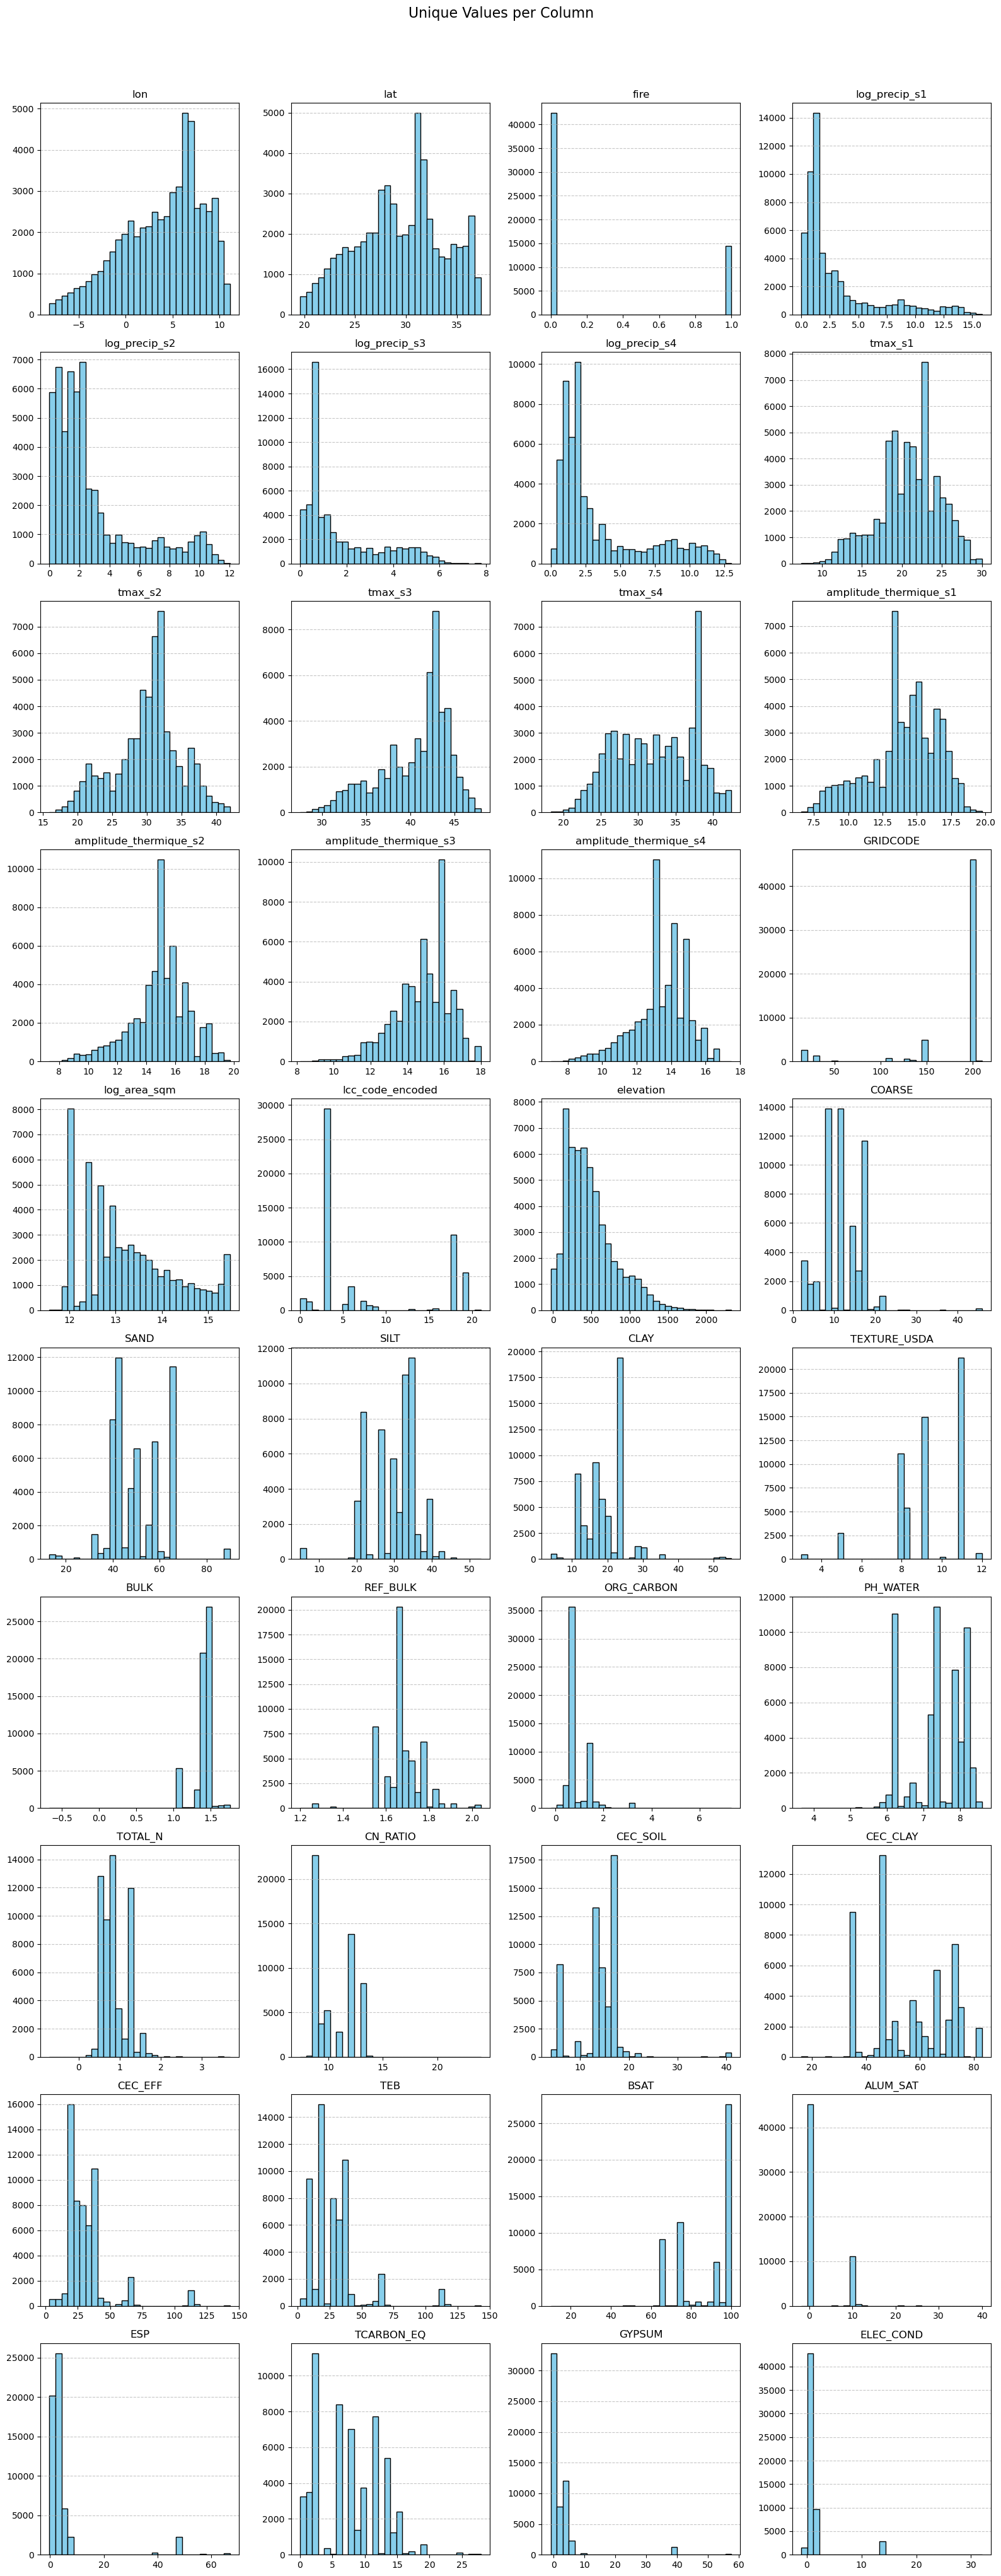

In [7]:
print("Loading merged dataset...")
merged_dataset = pd.read_parquet(r"../local_dataset/dataset/merged_full2.parquet", engine="fastparquet")
print("Merged dataset shape:", merged_dataset.shape)
merged_dataset.describe(include='all')

def plot_histograms(numeric_cols):
    cols_per_row = 4
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_histograms(merged_dataset.select_dtypes(include=[np.number]))


In [8]:

print("Number of nan values per column:")
print(merged_dataset.isna().sum())

Number of nan values per column:
lon                         0
lat                         0
fire                        0
log_precip_s1               0
log_precip_s2               0
log_precip_s3               0
log_precip_s4               0
tmax_s1                     0
tmax_s2                     0
tmax_s3                     0
tmax_s4                     0
amplitude_thermique_s1      0
amplitude_thermique_s2      0
amplitude_thermique_s3      0
amplitude_thermique_s4      0
GRIDCODE                    0
log_area_sqm                0
lcc_code_encoded            0
elevation                 926
COARSE                      0
SAND                        0
SILT                        0
CLAY                        0
TEXTURE_USDA                0
TEXTURE_SOTER               0
BULK                        0
REF_BULK                    0
ORG_CARBON                  0
PH_WATER                    0
TOTAL_N                     0
CN_RATIO                    0
CEC_SOIL                    0
CEC_CLA